# Screw anomalie detection using Autoencoders

**Considered problem:** In this notebook, our primary focus is to identify and distinguish between defective and non-defective screws using a series of images. Our ultimate goal is to leverage the power of machine learning models, specifically autoencoders, to flag defective screws in the test set accurately. This automated detection system aims to enhance the efficiency of the quality control process in manufacturing.

**Purpose / research question:** This notebook is designed with two overarching objectives in mind. The first one is to construct a base autoencoder model. This initial model will serve as our reference point for evaluating the effectiveness of various architectural tweaks and enhancements implemented in subsequent models. The sophistication and performance of this base model is not the crucial aspect at this stage; rather, the focus is on establishing a solid groundwork for future experimentation and comparison.

The second objective revolves around extensive experimentation and architectural diversification. We plan to design, train, and evaluate a range of autoencoder models with differing structures and complexities. This will involve exploring various image sizes and experimenting with straightforward data augmentation techniques. Our end goal is to identify the models that demonstrate the best performance and use them to build a robust, efficient, and precise defect detection system for screws.

The notebook is structured as follows:

<a id='top'></a>
[1. Data Inspection, Clean-Up & Preprocessing](#data-inspection) <br>
&emsp; [1.1 Load PV_01 Data and first look](#first-look) <br>
&emsp; [1.2 Dataset Overview](#overview) <br>
&emsp; [1.3 Feature reduction](#feature-reduction)<br>
&emsp; [1.4 Data deepdive](#deep-dive)<br>
[2. Linear regression baseline model](#baseline) <br>
[3. Stacking](#stacking) <br>
&emsp; [3.1 Initial model](#big-model) <br>
&emsp; [3.2 Model inspection and elimination](#model-inspection) <br>
&emsp; [3.3 Final results](#final-results) <br>
[4. Conclusion](#conclusion) <br>
&emsp; [4.1 Summary](#summary) <br>
&emsp; [4.2 Further Ideas](#ideas) <br>

## Import needed libraries

In [2]:
# scikit-learn
from sklearn.metrics import f1_score, recall_score, precision_score  # Function for computing the F1 score, a measure of classification accuracy

# torchviz
from torchviz import make_dot  # Utility function for creating visualizations of PyTorch computational graphs

# PyTorch
import torch  # Main PyTorch module providing tensors and neural network functionality
import torch.nn as nn  # Submodule with various neural network layers and loss functions
import torch.optim as optim  # Submodule with optimization algorithms for training neural networks
from torch.utils.data import DataLoader  # Data loading utility for creating data iterators
from torch.autograd import Variable  # Deprecated wrapper for tensors, previously used for automatic differentiation

# torchvision
from torchvision import datasets, transforms  # Submodule providing standard datasets and image transformations
from torchvision.datasets import DatasetFolder, ImageFolder  # Dataset classes for loading image data from folders
from torchvision.io import read_image  # Function for reading an image file and returning it as a tensor
from torchvision.transforms import ToTensor, Resize, Grayscale, Normalize, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter  # Image transformations
from torchvision.utils import save_image  # Function for saving an image tensor to disk

# tqdm
from tqdm import tqdm  # Library for creating progress bars and monitoring iteration progress

# PIL
from PIL import Image  # Main class in the Python Imaging Library (PIL) for image handling and manipulation

# Other
import numpy as np  # Library for numerical computations
import glob  # Module for finding files and directories using wildcard patterns
import utils  # Custom module or package providing additional utility functions or classes
import os  # Module for interacting with the operating system, accessing files and directories


In [3]:
# torch set seed
torch.manual_seed(42069)
# assign device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading the dataset and initial data exploration

### Dimension of images

When working with machine learning methods, the dimension of images plays a crucial role. It is important for images to have the same dimensions, as most machine learning models assume consistent-sized image inputs. This requirement arises due to several reasons inherent to the design and functionality of these models.

In [4]:
# Train data
print("Train data:")
utils.check_image_dimensions("screw_data/train/good")

# Test data
print("Test data:")
utils.check_image_dimensions("screw_data/test/good")
utils.check_image_dimensions("screw_data/test/manipulated_front")
utils.check_image_dimensions("screw_data/test/scratch_head")
utils.check_image_dimensions("screw_data/test/scratch_neck")
utils.check_image_dimensions("screw_data/test/thread_side")
utils.check_image_dimensions("screw_data/test/thread_top")

Train data:
All images have the same dimensions: (1024, 1024)
Test data:
All images have the same dimensions: (1024, 1024)
All images have the same dimensions: (1024, 1024)
All images have the same dimensions: (1024, 1024)
All images have the same dimensions: (1024, 1024)
All images have the same dimensions: (1024, 1024)
All images have the same dimensions: (1024, 1024)


All images (train and test) seem to have the same dimensions. We, therefore, do not need to resize them at this point.

### Taking a first look at the images

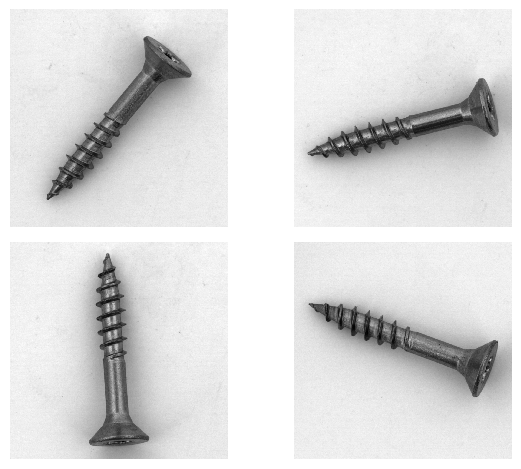

In [5]:
# open 4 train images and display them in a 2x2 grid
train_images = ["screw_data/train/good/000.png",
                "screw_data/train/good/055.png",
                "screw_data/train/good/123.png",
                "screw_data/train/good/291.png"]

utils.display_image_grid(train_images)

The train images predominantly feature a specific model of a screw, with slight variations in screw orientation. It appears that the dataset contains unique images, rather than duplicates or rotated versions of a single image. This uniqueness of images can be advantageous for data augmentation techniques.

Let's now look at some broken examples contained in the testset.

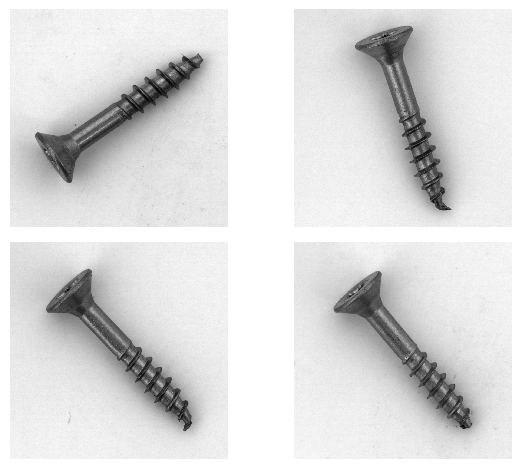

In [6]:
# get 4 random images form the manipulated front directory and display them in a 2x2 grid
#omitted for readability
# manipulated_front_image = glob.glob("screw_data/test/manipulated_front/*.png")
# manipulated_front_image = np.random.choice(manipulated_front_image, 4)
# print(manipulated_front_image)

manipulated_front_image = ['screw_data/test/manipulated_front/021.png',
 'screw_data/test/manipulated_front/005.png',
 'screw_data/test/manipulated_front/013.png',
 'screw_data/test/manipulated_front/001.png']

utils.display_image_grid(manipulated_front_image)

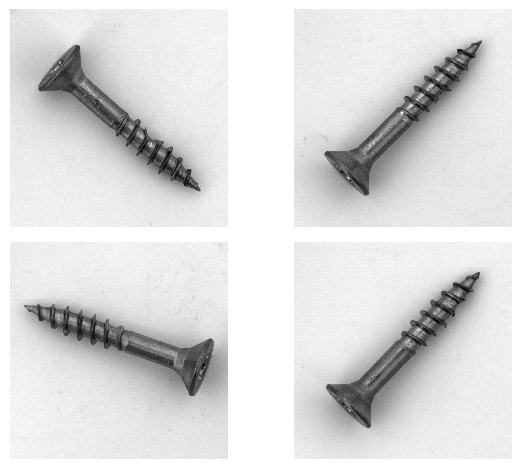

In [7]:
# get 4 random images form the thread side directory and display them in a 2x2 grid
#omitted for readability
#thread_side = glob.glob("screw_data/test/thread_side/*.png")
#thread_side = np.random.choice(thread_side, 4)
#print(thread_side)

thread_side = ['screw_data/test/thread_side/005.png',
 'screw_data/test/thread_side/009.png',
 'screw_data/test/thread_side/015.png',
 'screw_data/test/thread_side/004.png']

utils.display_image_grid(thread_side)

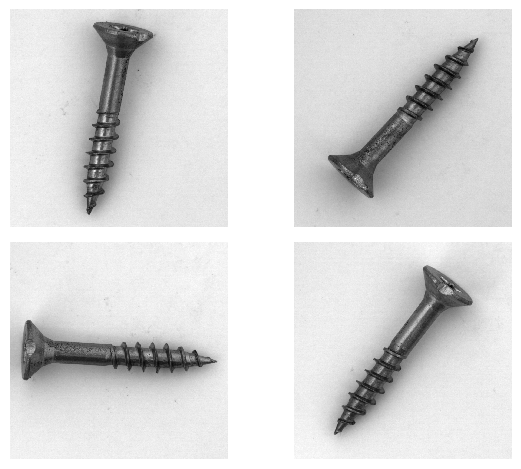

In [8]:
# get 4 random images form the scrath_head directory and display them in a 2x2 grid
# omitted for readability
#scratch_head_images = glob.glob("screw_data/test/scratch_head/*.png")
#scratch_head_images = np.random.choice(scratch_head_images, 4)
#print(scratch_head_images)

scratch_head_images = ['screw_data/test/scratch_head/003.png',
 'screw_data/test/scratch_head/019.png',
 'screw_data/test/scratch_head/007.png',
 'screw_data/test/scratch_head/004.png']

utils.display_image_grid(scratch_head_images)

Upon careful examination, it is apparent that the test images bear a strong resemblance to the train images, primarily owing to the presence of a consistent background. This similarity suggests that the visual characteristics and potential challenges encountered during the analysis of the train images are likely to be encountered in the test images as well.

Notably, when considering the screw objects depicted in the test images, it is evident that the errors present on the screws are generally minor. However, it is important to highlight that the category "manipulated front" displays more severe and easily detectable faults compared to other categories.

Furthermore, as all the images in the dataset are already grayscale, there seems to be no immediate need for preprocessing steps. However, data augmentation techniques can be applied after establishing a performance baseline to enhance the dataset's diversity and address potential challenges.

In [9]:
image_size = (128, 128)

In [10]:
transform = transforms.Compose([
    Resize(image_size),  # resize images
    Grayscale(),  # convert to grayscale
    ToTensor(),  # convert to tensor
])

# load all images in the 'good' directory
train_data = ImageFolder(root='screw_data/train', transform=transform)

# create a DataLoader to handle batching of images
train_data_loader = DataLoader(train_data, batch_size=24, shuffle=True)

In order to address the presence of redundant color information within the image data during the design of the encoders, it was necessary to convert the images to grayscale. Despite the visual appearance of lacking color, it became evident that the image data still retained three channels corresponding to red, green, and blue. Considering the non-informative nature of color in this context, a decision was made to convert the images to grayscale.

# Performance basline


Autoencoders are a type of artificial neural network used predominantly for unsupervised learning tasks, such as dimensionality reduction and feature extraction. They are self-supervised, meaning they generate their own labels from the input data, and are designed to learn an encoding of the input data - hence the term 'autoencoder'.

Autoencoders are comprised of two main components: an encoder, which maps the input data to a lower-dimensional space, and a decoder, which attempts to reconstruct the original input data from this lower-dimensional representation. The central idea is to learn a compressed, efficient representation of the input data, which captures its most salient features.

The process begins with the encoder. The input data is fed into the encoder, which is a neural network that reduces the dimensionality of the data. This process results in what is referred to as a 'bottleneck', where the data is compressed into a lower-dimensional space known as the latent space or the code.

Following the encoder is the decoder. The decoder is another neural network that takes the code from the encoder and attempts to reconstruct the original input data. The goal of the decoder is to produce output that is as close as possible to the original input.

The training of autoencoders is carried out using backpropagation. The difference between the original input and the reconstructed output (often calculated using a loss function such as mean squared error) is used to update the weights in the network. The idea is to minimize this reconstruction error, leading the autoencoder to learn an efficient and useful representation of the input data in the latent space.

![autoencoder](autoencoder.png)

In [11]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [12]:
baseline_encoder = Autoencoder()
optimizer = optim.Adam(baseline_encoder.parameters(), lr=1e-3)

In [13]:
def train(model, dataloader, num_epochs):
    model.train()
    loss_values = []

    for epoch in range(num_epochs):
        epoch_loss = 0
        progress_bar = tqdm(total=len(dataloader), desc=f'Epoch {epoch+1}', leave=False)
        
        for images, _ in dataloader:  # we don't need the labels, so we ignore them
            images = images.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = nn.MSELoss()(outputs, images)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            progress_bar.set_postfix({'Loss': loss.item()})
            progress_bar.update()
            
        progress_bar.close()
        epoch_loss = epoch_loss / len(dataloader)  # calculate average loss for the epoch
        loss_values.append(epoch_loss)

    return loss_values


In [14]:
# check if the baseline encoder file does not exists
if not os.path.isfile('baseline_encoder.pth'):
    # train the model
    loss = train(baseline_encoder, train_data_loader, num_epochs=100)
    # save loss values
    np.save('baseline_encoder_loss.npy', np.array(loss))
    # save the model
    torch.save(baseline_encoder.state_dict(), 'baseline_encoder.pth')
else:
    # load the model
    baseline_encoder.load_state_dict(torch.load('baseline_encoder.pth'))
    # load loss values
    loss = np.load('baseline_encoder_loss.npy')


To optimize training time, the model is trained only if a saved version does not exist. Consequently, after completing the training process, the trained model is saved to avoid unnecessary retraining. It is worth noting that the loss is saved solely for the purpose of this particular submission, as a means of documenting the training process.

### Let's evaluate the scores

In [15]:
# plot the loss
utils.plot_loss(loss)

Upon examining the loss during the training process, it became evident that the model was effectively minimizing the loss. Initially, when plotting the loss, the visual representation did not provide a clear understanding of the progress. To address this issue and improve visualization, a decision was made to utilize a logarithmic scale for the loss plot. This choice allowed for better comprehension of the loss reduction and facilitated a more accurate assessment of the model's performance over time.

In [16]:
test_dataset = utils.get_test_image_folder((128, 128))
class_names = test_dataset.classes
print(class_names)

['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']


We have loaded the test images, which are categorized into the following classes of screws:

- good: Represents images of screws without any defects or anomalies.
- manipulated_front: Represents images of screws with manipulations or alterations on the front side.
- scratch_head: Represents images of screws with scratches on the head portion.
- scratch_neck: Represents images of screws with scratches on the neck portion.
- thread_side: Represents images of screws with thread-related issues on the side.
- thread_top: Represents images of screws with thread-related issues on the top.

These classes define different types of screw conditions and defects that are relevant for evaluation and testing purposes.

In [17]:
class_encoding = utils.get_class_encodings(baseline_encoder, test_dataset, device)
class_means, class_mses = utils.calculate_class_stats(class_encoding)
utils.plot_class_stats(class_means, class_mses, class_names)


The plot shows the mean and mean squared error (MSE) values per class, indicating that the model should be able to differentiate between the "good" and "broken" images effectively. However, distinguishing between the different categories of defects within the broken classes may present a challenge, as suggested by the similarity in metrics. Nevertheless, in a production setting, the specific type of defect on the screw may not be of primary importance. Instead, the main concern would be to identify whether a screw is broken or not. Therefore, the model's ability to accurately classify screws as either "good" or "broken" is likely to be the most critical factor in practical applications.

In [18]:
def calculate_f1(model, test_dataset):
    # predict the class of each image in the test set
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Assume that `autoencoder` is your trained model and `data_loader` is your test data loader
    # and that you are using Mean Squared Error (MSE) loss
    criterion = nn.MSELoss()

    # Calculate the reconstruction errors and the labels for the test set
    reconstruction_errors = []
    labels = []
    for images, targets in test_loader:
        # Move the images and targets to the GPU if available
        images = images.to(device)
        targets = targets.to(device)
        
        # Run the images through the autoencoder
        outputs = model(images)
        
        # Calculate the reconstruction error
        loss = criterion(outputs, images)
        
        # Save the reconstruction error and the true label
        reconstruction_errors.append(loss.item())
        labels.append(targets.item())

    # Convert to numpy arrays for easier manipulation
    reconstruction_errors = np.array(reconstruction_errors)
    labels = np.array(labels)

    # Calculate the threshold as 2 times the standard deviation of the reconstruction errors of the good images
    threshold = 2 * np.std(reconstruction_errors[labels == 0]) + np.mean(reconstruction_errors[labels == 0])

    # Predict the labels based on the reconstruction errors
    predicted_labels = (reconstruction_errors > threshold).astype(int)

    adapted_labels = labels.copy()
    # turn it into two classes 0 = 0 and > 0 = 1
    adapted_labels[adapted_labels > 0] = 1

    recall = recall_score(adapted_labels, predicted_labels)
    print('Recall:', recall)
    precision = precision_score(adapted_labels, predicted_labels)
    print('Precision:', precision)

    # Calculate the F1 score of the predictions
    f1 = f1_score(adapted_labels, predicted_labels)
    print('F1 Score:', f1)
    print("Labels: ", adapted_labels)
    print("Predicted Labels: ", predicted_labels)
    return adapted_labels, predicted_labels, f1

The function calculate_f1 evaluates a model's performance on a test dataset by calculating the F1 score. It processes each image in the dataset through the model, calculates the reconstruction error, and classifies the image as 'good' or 'bad' based on this error. The F1 score is then computed to provide a measure of the model's accuracy.

The threshold in this function is calculated as two times the standard deviation of the reconstruction errors of the "good" images (those with a label of 0), plus the mean of these errors. This is a common approach in anomaly detection models, where the goal is to identify data points that significantly deviate from the norm.

The standard deviation measures the amount of variation or dispersion in a set of values. A low standard deviation indicates that the values tend to be close to the mean, while a high standard deviation indicates that the values are spread out over a wider range.

By setting the threshold to two times the standard deviation plus the mean, we are essentially saying that any image with a reconstruction error that is more than two standard deviations away from the mean is considered an anomaly or a "bad" image. This is based on the empirical rule or the 68-95-99.7 rule in statistics, which states that for a normal distribution, about 95% of the data falls within two standard deviations of the mean. Therefore, data points that fall outside of this range are considered unusual or anomalous.

In [19]:
labels, predicted_labels, f1 = calculate_f1(baseline_encoder, test_dataset)

Recall: 0.36134453781512604
Precision: 1.0
F1 Score: 0.5308641975308642
Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1
 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0
 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1
 1 1 1 0 1 1 0 1 1 0 0 0]


The initial F1 score for our model stands at 0.53. It's a reasonable start, but without a point of comparison, it's tricky to gauge how significant that is. The true evaluation of the score's adequacy can only come in relation to the performance of other models tackling the same task or a set benchmark. So, we'll need more analysis and comparisons for an accurate performance assessment.

Notably, our model is showing perfect precision with a score of 1.0. The bottleneck here seems to be recall, which is currently holding back our overall performance. This suggests that we need to focus on improving the model's ability to detect broken screws, which will help in raising our F1 score. 


In [20]:
# Lets explore some of the images that were misclassified
def display_misclassified_images(test_dataset, labels, predicted_labels):
    print("Number of test images:", len(test_dataset))
    # get the indices of the misclassified images
    misclassified_indices = np.where(labels != predicted_labels)[0]
    print('Number of misclassified images:', len(misclassified_indices))
    print("Number of false positives:", np.sum(predicted_labels > labels))
    print("Number of false negatives:", np.sum(labels > predicted_labels))
    # get the misclassified images
    misclassified_images = []
    for i in misclassified_indices:
        misclassified_images.append(test_dataset[i])
    
    # display the misclassified images
    # Loop over to display the images
    for i in range(0, len(misclassified_images), 4):
        if i > 8:
            # only display 12 images
            break
        utils.display_image_grid(misclassified_images[i:i+4])


Number of test images: 160
Number of misclassified images: 76
Number of false positives: 0
Number of false negatives: 76


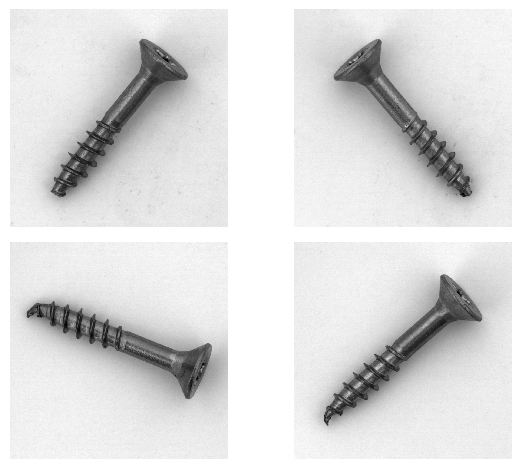

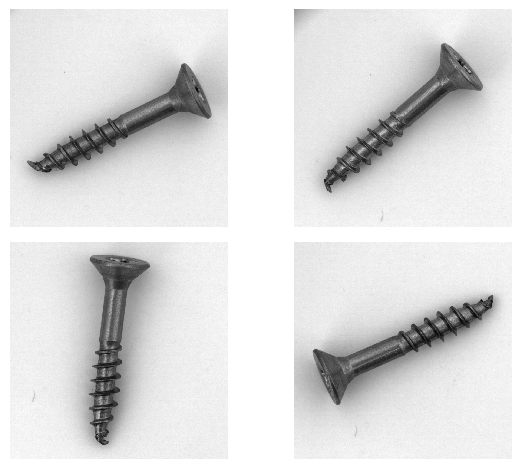

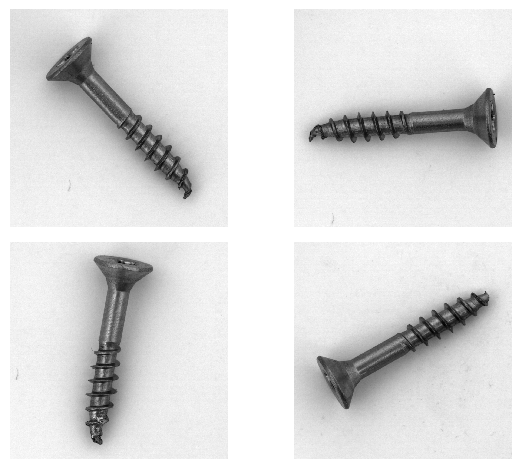

In [21]:
test_dataset = utils.get_test_image_folder((128, 128))
test_images = ImageFolder(root='screw_data/test')
image_paths = [sample[0] for sample in test_images.samples]
display_misclassified_images(image_paths, labels, predicted_labels)

Even though the defects in some of these images aren't severe, it's still pretty clear that all these screws have defects. This indicates that our model isn't quite nailing the concept of what a non-defective screw should look like. So, it seems we still have some work to do on improving its understanding and detection capabilities.

# Increasing complexity to boost performance 

In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


Switching gears to our second architecture, we're now working with a more complex autoencoder model. Instead of two, we've got three convolutional layers in our encoder and three transpose convolutional layers in the decoder. This additional layer allows our model to learn more nuanced features from the images. 

What's more, we've ramped up the number of filters in each layer. Starting with 32 in the first, up to 64 in the second, and then back down to 32. This growth and reduction pattern facilitates a more robust feature learning process, capturing detailed patterns that could be crucial in distinguishing defective screws.

Finally, we've also made a tweak in the final layer of the decoder where we've introduced a Sigmoid activation function. This addition is especially useful when working with images. The Sigmoid function crunches our output between 0 and 1, matching the usual range for pixel intensities. This could lead to a better quality of image reconstruction, and in turn, improve our defect detection performance.

In essence, the more complex architecture and use of the Sigmoid function in our second model should enable us to capture more complex features and enhance the reconstruction quality, which could potentially boost our model's ability to spot defective screws.


In [23]:
bigger_autoencoder = Autoencoder()
optimizer = optim.Adam(bigger_autoencoder.parameters(), lr=1e-3)

In [24]:
# check if the baseline encoder file does not exists
if not os.path.isfile('bigger_autoencoder.pth'):
    # train the model
    loss = train(bigger_autoencoder, train_data_loader, num_epochs=100)
    # save loss values
    np.save('bigger_autoencoder_loss.npy', np.array(loss))
    # save the model
    torch.save(bigger_autoencoder.state_dict(), 'bigger_autoencoder.pth')
else:
    # load the model
    bigger_autoencoder.load_state_dict(torch.load('bigger_autoencoder.pth'))
    # load loss values
    loss = np.load('bigger_autoencoder_loss.npy')


In [25]:
# plot the loss
utils.plot_loss(loss)

Looking at our training logs, we're seeing a consistent decrease in the loss over time. This steady decline is a positive sign, hinting that our model is likely picking up and learning the important features from our data. Fingers crossed that this learning translates into better detection of defective screws.


In [26]:
class_encoding = utils.get_class_encodings(bigger_autoencoder, test_dataset, device)
class_means, class_mses = utils.calculate_class_stats(class_encoding)
utils.plot_class_stats(class_means, class_mses, class_names)

In [27]:
labels, predicted_labels, f1 = calculate_f1(bigger_autoencoder, test_dataset)

Recall: 0.17647058823529413
Precision: 0.84
F1 Score: 0.29166666666666674
Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Labels:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0
 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0]


Upon receiving the updated metrics, it appears that the performance of our model has unfortunately regressed. The recall has significantly diminished to approximately 0.168, suggesting a decreased effectiveness in identifying defective screws. Although the precision remains relatively high at 0.84, the F1 Score, a more comprehensive measure of model performance, has reduced to around 0.29.

This indicates that our model, while retaining a commendable ability to accurately predict non-defective screws, is considerably struggling to detect the defective ones. Thus, to balance out these metrics and enhance the overall performance, it will be crucial to refine our model further, focusing on improving its capacity to accurately identify defective screws.

# Increas training time

In [28]:
bigger_autoencoder_big = Autoencoder()
optimizer = optim.Adam(bigger_autoencoder_big.parameters(), lr=1e-3)

WE KEEEP THE SAME ARCHITECTURE 

In [29]:
train_data_loader = utils.get_regular_train_loader(image_size=(128, 128), batch_size=24)

In [30]:
# check if the baseline encoder file does not exists
if not os.path.isfile('bigger_autoencoder_500.pth'):
    # train the model
    loss = train(bigger_autoencoder_big, train_data_loader, num_epochs=500)
    # save loss values
    np.save('bigger_autoencoder_loss_500.npy', np.array(loss))
    # save the model
    torch.save(bigger_autoencoder_big.state_dict(), 'bigger_autoencoder_500.pth')
else:
    # load the model
    bigger_autoencoder_big.load_state_dict(torch.load('bigger_autoencoder_500.pth'))
    # load loss values
    loss = np.load('bigger_autoencoder_loss_500.npy')


In [31]:
# plot the loss
utils.plot_loss(loss)

In [32]:
class_encoding = utils.get_class_encodings(bigger_autoencoder_big, test_dataset, device)
class_means, class_mses = utils.calculate_class_stats(class_encoding)
utils.plot_class_stats(class_means, class_mses, class_names)

In [33]:
labels, predicted_labels, f1 = calculate_f1(bigger_autoencoder_big, test_dataset)

Recall: 0.16806722689075632
Precision: 0.9090909090909091
F1 Score: 0.2836879432624114
Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0
 0 0 0 0 1 0 0 0 1 0 0 0]


# Another architecture

In [34]:
# Autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [35]:
benchmark_scaled = Autoencoder()
optimizer = optim.Adam(benchmark_scaled.parameters(), lr=1e-3)

In [36]:
transform = transforms.Compose([
    Resize(image_size),  # resize images
    Grayscale(),  # convert to grayscale
    ToTensor(),  # convert to tensor
])

# load all images in the 'good' directory, assuming they're all good
train_data = ImageFolder(root='screw_data/train', transform=transform)

# create a DataLoader to handle batching of images
train_data_loader = DataLoader(train_data, batch_size=24, shuffle=True)

In [37]:
# check if the baseline encoder file does not exists
if not os.path.isfile('model/benchmark_scaled_sigmoid.pth'):
    # train the model
    loss = train(benchmark_scaled, train_data_loader, num_epochs=100)
    # save loss values
    np.save('loss/benchmark_scaled_sigmoid.npy', np.array(loss))
    # save the model
    torch.save(benchmark_scaled.state_dict(), 'model/benchmark_scaled_sigmoid.pth')
else:
    # load the model
    benchmark_scaled.load_state_dict(torch.load('model/benchmark_scaled_sigmoid.pth'))
    # load loss values
    loss = np.load('loss/benchmark_scaled_sigmoid.npy')


In [38]:
# plot the loss
utils.plot_loss(loss)

In [39]:
class_encoding = utils.get_class_encodings(benchmark_scaled, test_dataset, device)
class_means, class_mses = utils.calculate_class_stats(class_encoding)
utils.plot_class_stats(class_means, class_mses, class_names)

In [40]:
labels, predicted_labels, f1 = calculate_f1(benchmark_scaled, test_dataset)

Recall: 0.15966386554621848
Precision: 0.95
F1 Score: 0.27338129496402874
Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Labels:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 1
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0]


## Let's increase image size

In [41]:
transform = transforms.Compose([
    Resize((256, 256)),  # resize images
    Grayscale(),  # convert to grayscale
    ToTensor(),  # convert to tensor
])

# load all images in the 'good' directory, assuming they're all good
train_data = ImageFolder(root='screw_data/train', transform=transform)

# create a DataLoader to handle batching of images
train_data_loader = DataLoader(train_data, batch_size=16, shuffle=True)


In [42]:
bigger_autoencoder_256 = Autoencoder()
optimizer = optim.Adam(bigger_autoencoder_256.parameters(), lr=1e-3)

In [43]:
# check if the baseline encoder file does not exists
if not os.path.isfile('model/bigger_autoencoder_256.pth'):
    # train the model
    loss = train(bigger_autoencoder_256, train_data_loader, num_epochs=100)
    # save loss values
    np.save('loss/bigger_autoencoder_256.npy', np.array(loss))
    # save the model
    torch.save(bigger_autoencoder_256.state_dict(), 'model/bigger_autoencoder_256.pth')
else:
    # load the model
    bigger_autoencoder_256.load_state_dict(torch.load('model/bigger_autoencoder_256.pth'))
    # load loss values
    loss = np.load('loss/bigger_autoencoder_256.npy')


In [44]:
# plot the loss
utils.plot_loss(loss)

In [45]:
class_encoding = utils.get_class_encodings(bigger_autoencoder_256, test_dataset, device)
class_means, class_mses = utils.calculate_class_stats(class_encoding)
utils.plot_class_stats(class_means, class_mses, class_names)

In [46]:
labels, predicted_labels, f1 = calculate_f1(bigger_autoencoder_256, test_dataset)

Recall: 0.35294117647058826
Precision: 1.0
F1 Score: 0.5217391304347826
Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1
 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1
 1 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 1 0 0 0 0 0]


## Let's try some data augmentation

In [47]:
augmentation_transform = transforms.Compose([
    Resize((256, 256)),  # resize images
    Grayscale(),  # convert to grayscale
    RandomHorizontalFlip(),  # randomly flip image on horizontal axis
    RandomVerticalFlip(),  # randomly flip image on vertical axis
    #RandomRotation(20),  # randomly rotate image in the range [-20, 20] degrees
    ToTensor(),  # convert to tensor
])

# load all images in the 'good' directory, assuming they're all good
train_data = ImageFolder(root='screw_data/train', transform=augmentation_transform)

# create a DataLoader to handle batching of images
train_data_loader = DataLoader(train_data, batch_size=16, shuffle=True)


In [48]:
conv_autoencoder = Autoencoder()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=1e-3)

In [49]:
# train the model
if not os.path.isfile('model/image_augmentation_256.pth'):
    # train the model
    loss = train(conv_autoencoder, train_data_loader, num_epochs=100)
    # save loss values
    np.save('loss/image_augmentation_256.npy', np.array(loss))
    # save the model
    torch.save(conv_autoencoder.state_dict(), 'model/image_augmentation_256.pth')
else:
    # load the model
    conv_autoencoder.load_state_dict(torch.load('model/image_augmentation_256.pth'))
    # load loss values
    loss = np.load('loss/image_augmentation_256.npy')


In [50]:
utils.plot_loss(loss)

In [51]:
test_dataset = ImageFolder(root='screw_data/test', transform=transform)
class_names = test_dataset.classes
print(class_names)

['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']


In [52]:
labels, predicted_labels, f1 = calculate_f1(conv_autoencoder, test_dataset)

Recall: 0.3277310924369748
Precision: 0.9512195121951219
F1 Score: 0.48750000000000004
Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Labels:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1
 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1
 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 1 0 1 0 1 1 0 1 0 1 0 0]


In [53]:
class_encoding = utils.get_class_encodings(conv_autoencoder, test_dataset, device)
class_means, class_mses = utils.calculate_class_stats(class_encoding)
utils.plot_class_stats(class_means, class_mses, class_names)

# Width dropout layers

In [54]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),  
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2)  
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),  
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


RERUN WITH 256 image size

In [55]:
autoencoder_dropout = Autoencoder()
optimizer = optim.Adam(autoencoder_dropout.parameters(), lr=1e-3)
train_data_loader = utils.get_regular_train_loader((128, 128), 24)


In [56]:
if not os.path.isfile('model/autoencoder_dropout_relu.pth'):
    # train the model
    loss = train(autoencoder_dropout, train_data_loader, num_epochs=100)
    # save loss values
    np.save('loss/autoencoder_dropout_relu.npy', np.array(loss))
    # save the model
    torch.save(autoencoder_dropout.state_dict(), 'model/autoencoder_dropout_relu.pth')
else:
    # load the model
    autoencoder_dropout.load_state_dict(torch.load('model/autoencoder_dropout_relu.pth'))
    # load loss values
    loss = np.load('loss/autoencoder_dropout_relu.npy')


In [57]:
utils.plot_loss(loss)

Recall: 0.7478991596638656
Precision: 0.978021978021978
F1 Score: 0.8476190476190475
Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted Labels:  [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1
 0 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 1 0 0 1 0 0 1 1
 1 1 1 0 1 1 1 1 1 1 0 1]
Number of test images: 160
Number of misclassified images: 32
Number of false positives: 2
Number of false negatives: 30


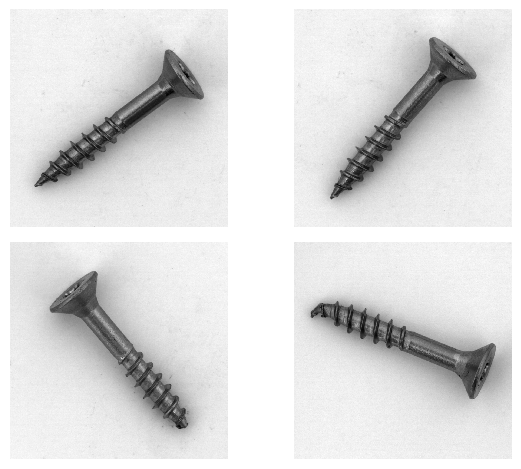

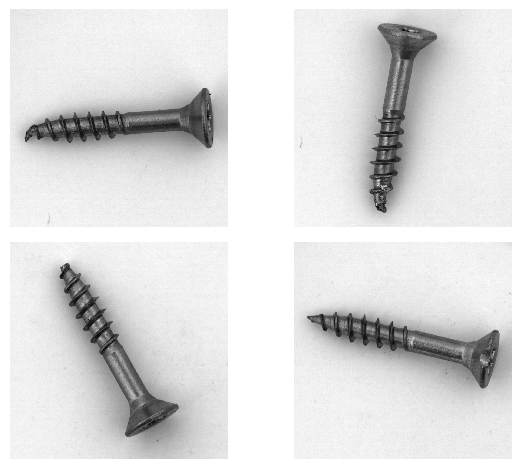

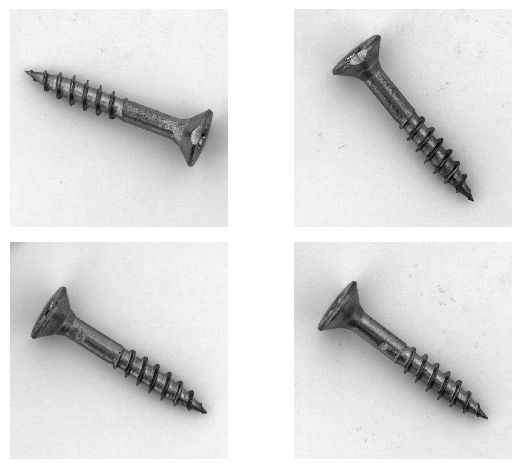

In [58]:
test_dataset = utils.get_test_image_folder((128, 128))
labels, predicted_labels, f1 = calculate_f1(autoencoder_dropout, test_dataset)
test_images = ImageFolder(root='screw_data/test')
image_paths = [sample[0] for sample in test_images.samples]
display_misclassified_images(image_paths, labels, predicted_labels)

As this score is very good we can increase the thershold from 2 times the standard deviation to 3 times.